In [ ]:
from google.colab import drive
drive.mount ('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# BreakHis Dataset
!mkdir '/content/bh'
!unzip -qq '/content/gdrive/MyDrive/BreaKHis_v1.zip'  -d '/content/BH'
!unzip -qq '/content/gdrive/MyDrive/Folds.csv.zip'  -d '/content/BH'

# 1st Phase - VGG16 + Transfer Learning ImageNet - BreakHis

## BH SECTION

### IMPORTING LIBRARIES

In [ ]:
# importing libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf
from functools import partial
# import keras
from tensorflow.keras import layers
import albumentations as A
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import KFold
import matplotlib as mpl
from matplotlib.image import imread
from tqdm import tqdm_notebook
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os, warnings, random, time, multiprocessing, pickle

### GPU CONFIRMATION

In [ ]:
!nvidia-smi

Thu Sep 21 19:04:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### LOADING Dataframes

In [ ]:
image_dir = '/content/BH/' #TRAIN_DIR
data_path = '/content/BH/Folds.csv' #TEST_DIR

# experimental API for making data pipelines
tf.data.experimental.AUTOTUNE

# defining the class names
class_names = ['malignant', 'benign']
print(class_names)

['malignant', 'benign']


In [ ]:
# loading the data
data = pd.read_csv(data_path)
data.head(5)

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [ ]:
data['fold'].value_counts()

1    7909
2    7909
3    7909
4    7909
5    7909
Name: fold, dtype: int64

### DATA STRUCTURE

In [ ]:
# renaming and structuring the columns for better data understanding
data = data.rename(columns={'filename': 'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])

In [ ]:
# view first n rows of strucrured data
data.head(6)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-005.png
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549AB-100-006.png


In [ ]:
data.shape

(39545, 7)

### DATA ANALYSIS

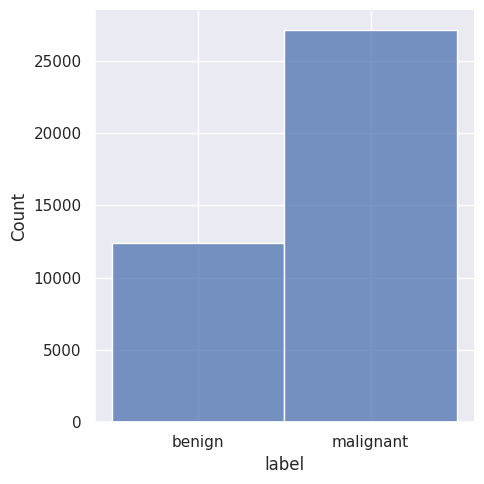

In [ ]:
# making a plot to see data distribution
# sns.figure()
sns.set_theme()
sns.displot(x='label', data=data)

<Axes: xlabel='label', ylabel='count'>

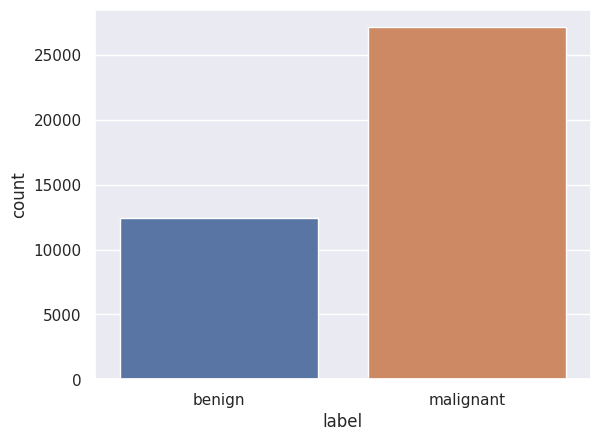

In [ ]:
sns.countplot(x=data['label'], data=data)

### Dataset Modelling for Deep Learning

In [ ]:
# sorting out training and testing images
test_images = data.groupby(by='label').sample(3000)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)

In [ ]:
# making splits of training and testing datasets
train_images = train_images.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)

In [ ]:
print('Total training images: % s' % str(train_images.shape[0]))
print('Total testing images: % s' % str(test_images.shape[0]))

Total training images: 27545
Total testing images: 6000


In [ ]:
train_images['set'] = 'train'
test_images['set'] = 'test'

In [ ]:
new_data = pd.concat([train_images, test_images])
new_data.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,1,40,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0,SOB_M_DC-14-6241-40-006.png,train
1,1,40,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0,SOB_M_DC-14-6241-40-008.png,train
2,1,40,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0,SOB_M_DC-14-6241-40-010.png,train
3,1,40,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0,SOB_M_DC-14-6241-40-012.png,train
4,1,40,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0,SOB_M_DC-14-6241-40-014.png,train


### Visualizing Train & Test Splits

<Axes: xlabel='label', ylabel='count'>

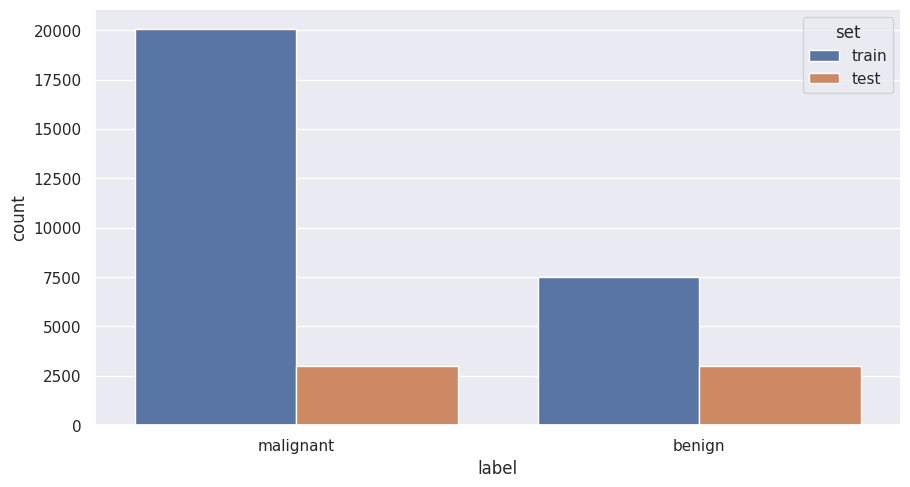

In [ ]:
sns.set(rc={'figure.figsize':(10.4, 5.4)})
sns.countplot(x=new_data['label'], hue=new_data['set'])

### Unsampling Data

In [ ]:
max_count = np.max(train_images.label.value_counts())
min_count = np.min(train_images.label.value_counts())
train_images = train_images.groupby('label').sample(n=max_count, replace=True)
train_images = train_images.reset_index(drop=True)

In [ ]:
train_images.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,3,40,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-21998EF-40-005.png,train
1,5,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-25197-200-052.png,train
2,5,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_PT-14-22704-400-017.png,train
3,5,200,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_A-14-22549CD-200-031.png,train
4,4,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-21998CD-400-024.png,train


In [ ]:
max_count = np.max(test_images.label.value_counts())
min_count = np.min(test_images.label.value_counts())
test_images = test_images.groupby('label').sample(n=max_count, replace=True)
test_images = test_images.reset_index(drop=True)

In [ ]:
test_images.head(5)

,fold,mag,grp,path,label,label_int,filename,set
0,4,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-14134E-400-011.png,test
1,3,40,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-14134-40-032.png,test
2,2,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-21998CD-400-024.png,test
3,3,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-9133-400-011.png,test
4,4,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-23060CD-400-008.png,test


## CNN Variables

In [ ]:
# Model Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Variables

kernel_size     = (3,3)
pool_size       = (2,2)
input_shape_bk  = (640, 640, 3) #9109 RGB
input_shape_pc  = (96, 96, 3) #327680 RGB
target_shape    = (224, 224)
batch_size      = 32
epochs          = 5
seed            = 1337
img_size        = 224
num_filters     = 4

first_filters   = 32
second_filters  = 64
third_filters   = 128
fouth_filters   = 256

dropout_conv = 0.3
dropout_dense = 0.3

early_stopping  = EarlyStopping(
        monitor = 'val_acc',
      min_delta = 0.001,
       patience = 5,
        verbose = 1,
           mode = 'auto')

reduce_lr    = ReduceLROnPlateau(
    monitor  ='val_acc',
    factor   = 0.5,
    patience = 2,
    verbose  = 1,
    mode     = 'max',
    min_lr   = 0.00001)

optimizer       = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)                 # SGD(lr=0.001, momentum=0.9), Adam, RMSprop
loss            = 'binary_crossentropy'                      # 'categorical_crossentropy', 'binary_crossentropy'
metric          = 'accuracy'
activation      = 'sigmoid'                                  # 'sigmoid'; 'softmax'
split_size     = 0.2

## Load Data

In [ ]:
image_dir = "/content/BH/"
(image_dir + train_images.path)[0]
print(train_images.path)
print(image_dir)

0        BreaKHis_v1/histology_slides/breast/benign/SOB...
1        BreaKHis_v1/histology_slides/breast/benign/SOB...
2        BreaKHis_v1/histology_slides/breast/benign/SOB...
3        BreaKHis_v1/histology_slides/breast/benign/SOB...
4        BreaKHis_v1/histology_slides/breast/benign/SOB...
                               ...                        
40085    BreaKHis_v1/histology_slides/breast/malignant/...
40086    BreaKHis_v1/histology_slides/breast/malignant/...
40087    BreaKHis_v1/histology_slides/breast/malignant/...
40088    BreaKHis_v1/histology_slides/breast/malignant/...
40089    BreaKHis_v1/histology_slides/breast/malignant/...
Name: path, Length: 40090, dtype: object
/content/BH/


In [ ]:
# loading the train & validation datasets
load_train = tf.data.Dataset.from_tensor_slices((image_dir + "/" + train_images.path,
                                                train_images.label_int))

load_test = tf.data.Dataset.from_tensor_slices((image_dir + "/" + test_images.path,
                                                test_images.label_int))

In [ ]:
# function to decode a PNG image into a tf tensor
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    return image, label

# image argumentation for faster model training
def argument_image(image):
    transform = A.Compose([A.HorizontalFlip(p = 0.5),
                          A.Rotate(p = 0.5, limit = 15),
                          A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1),
                                                    brightness_by_max=True),
                           A.RandomResizedCrop(p=0.8, height=img_size, width=img_size,
                                              scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
                           A.Blur(blur_limit = (1, 1))

                          ])

    data = {"image": image}
    argumented_data = transform(**data)
    argumented_image = argumented_data["image"]
    argumented_image = tf.cast(argumented_image, tf.float32)
    argumented_image = tf.image.resize(argumented_image, [img_size, img_size]) / 255

    return argumented_image

def argumentor_function(image, label):
    argumented_image = tf.numpy_function(func = argument_image, inp=[image], Tout = tf.float32)
    return argumented_image, label

In [ ]:
train_dataset = (
                load_train.shuffle(len(train_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )
test_dataset = (
                load_test.shuffle(len(test_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Making the VGG16 Deep Learning Model

In [ ]:
import keras

### Building the Base Model

train_steps = np.ceil(len(train_dataset) / batch_size)
test_steps = np.ceil(len(test_dataset) / batch_size)

print('Steps:')
print('Train: %d | Test: %d ' %(train_steps, test_steps))

input_shape = (640, 640, 3)
def model_vgg16(input_shape, activation):

    model = tf.keras.applications.vgg16.VGG16(
        input_shape   = input_shape,
        include_top   = False,
        weights = 'imagenet')

    x = model.layers[-1].output
    # model.layers.pop()
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(1, activation=activation)(x)
    print('Output shape: ', output.shape)
    model.trainable = False
    model = keras.Model(inputs=model.input, outputs=output)

    return model

if __name__ == "__main__":
    model = model_vgg16(input_shape, activation)
    model.summary()
    print('Input shape: ', input_shape)

Steps:
Train: 40 | Test: 6 
58889256/58889256 [==============================] - 0s 0us/step
Output shape:  (None, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 640, 640, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 640, 640, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 640, 640, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 320, 320, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 320, 320, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 320, 320, 128)     147584    
         

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=88b7bf1dab255f0c10e4632b8cf3ac78710a34c55ca109614094dfc6c40fa3ca
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


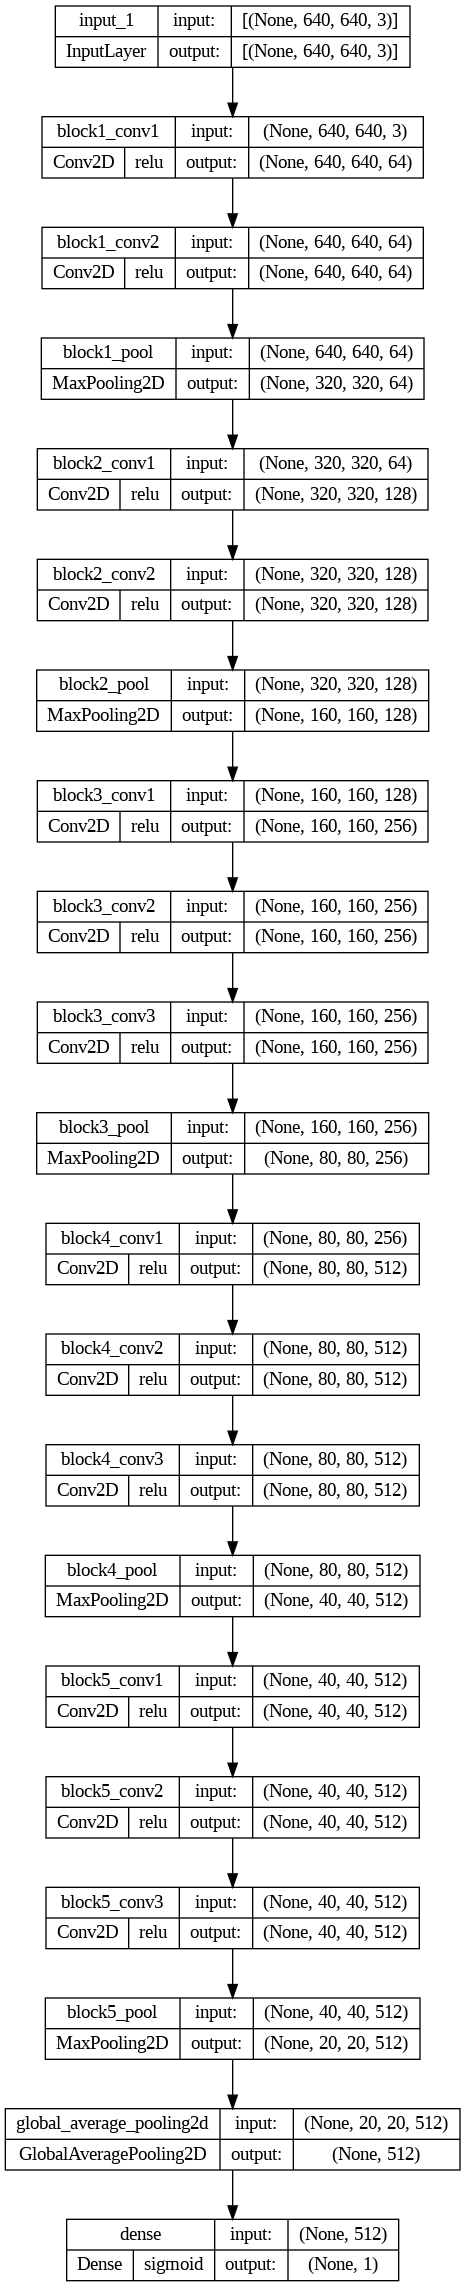

In [ ]:
!pip install visualkeras
!pip install ann_visualizer
!pip install graphviz

# Import necessary libraries
import pandas as pd
import numpy as np                               # Import numpy
from skimage import data, io   # Import skimage library (data - Test images and example data.
#                          io - Reading, saving, and displaying images.)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt                  # Import matplotlib.pyplot (Plotting framework in Python.)
%matplotlib inline
import os                                        # This module provides a portable way of using operating system dependent functionality.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
from IPython.display import display
import cv2 as cv
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

tf.keras.utils.plot_model(
model,
to_file="model.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

## Plot Train Imgs

In [ ]:
#####################  Plot Loss Curves  #####################

def Plot_Train(hlist, start=1):

    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])

    epoch_range = range(start, len(history['loss']) +1)
    s           = slice(start-1, None)
    n           = int(len(history.keys()) / 2)

    plt.figure(figsize=[14,4])
    for i in range(n):
        k = list(history.keys())[i]
        plt.subplot(1, n, i+1)
        plt.plot(epoch_range, history[k][s], label='Training')
        plt.plot(epoch_range, history['val_' + k][s], label='Test')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

# 1st Train - VGG16 + Transfer Learning ImageNet - BreakHis

In [ ]:

start = time.time()
# starting a new sesion for TF
from keras import backend as K

tf.keras.backend.clear_session()

# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('1st_train_vgg16_model.h5', save_best_only=True)

# model logs
csv_logger = CSVLogger('cnn_vgg16_1strain_model_logs.csv', append=True)

metrics = ['accuracy', Precision(name='Precision'), Recall(name='Recall')]

# compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

# fit the model
train_history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size, verbose=1,
                             callbacks=[model_checkpoint, csv_logger], validation_data=test_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Epoch 1/5
1253/1253 [==============================] - 316s 242ms/step - loss: 0.6049 - accuracy: 0.6884 - Precision: 0.6821 - Recall: 0.7055 - val_loss: 0.5513 - val_accuracy: 0.7313 - val_Precision: 0.7758 - val_Recall: 0.6507
Epoch 2/5
1253/1253 [==============================] - 296s 236ms/step - loss: 0.5209 - accuracy: 0.7619 - Precision: 0.7608 - Recall: 0.7641 - val_loss: 0.5008 - val_accuracy: 0.7692 - val_Precision: 0.8048 - val_Recall: 0.7107
Epoch 3/5
1253/1253 [==============================] - 296s 236ms/step - loss: 0.4837 - accuracy: 0.7837 - Precision: 0.7824 - Recall: 0.7860 - val_loss: 0.4671 - val_accuracy: 0.7982 - val_Precision: 0.7975 - val_Recall: 0.7993
Epoch 4/5
1253/1253 [==============================] - 296s 237ms/step - loss: 0.4593 - accuracy: 0.8000 - Precision: 0.7988 - Recall: 0.8018 - val_loss: 0.4513 - val_accuracy: 0.8075 - val_Precision: 0.8256 - val_Recall: 0.7797
Epoch 5/5
1253/1253 [==============================] - 295s 235ms/step - loss: 0.443

### 1st VGG16 Results

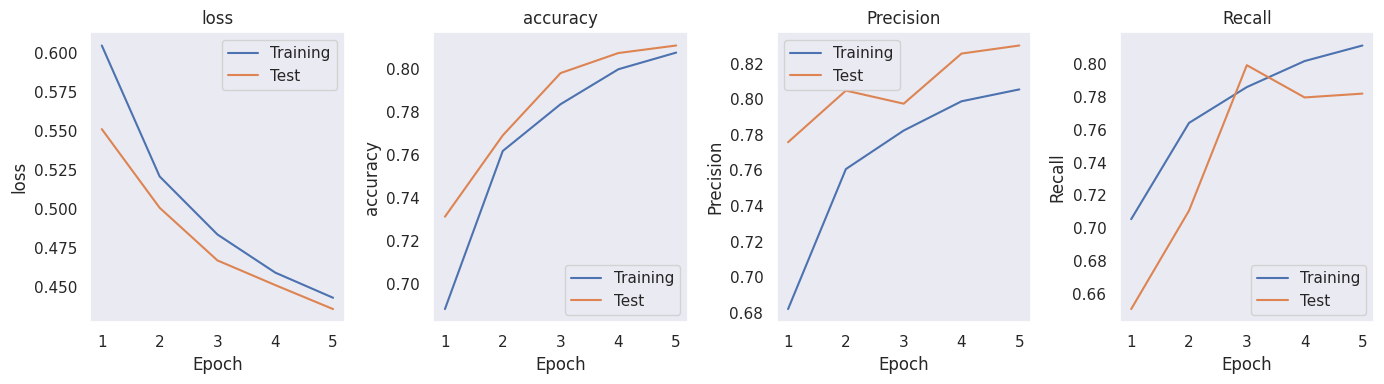

In [ ]:
Plot_Train([train_history])

## Conf Matrix

In [ ]:
test_images

,fold,mag,grp,path,label,label_int,filename,set
0,4,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-14134E-400-011.png,test
1,3,40,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-14134-40-032.png,test
2,2,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-21998CD-400-024.png,test
3,3,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-9133-400-011.png,test
4,4,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,1,SOB_B_F-14-23060CD-400-008.png,test
...,...,...,...,...,...,...,...,...
5995,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0,SOB_M_MC-14-16456-400-058.png,test
5996,2,100,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0,SOB_M_DC-14-2985-100-009.png,test
5997,3,400,train,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0,SOB_M_DC-14-16716-400-009.png,test
5998,4,40,test,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,0,SOB_M_DC-14-18650-40-007.png,test


In [ ]:
test_data = load_test
test_dataset = (
                test_data
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# get field by concatenating batches
ytrue = test_images['label_int']
pred = model.predict_generator(test_dataset, verbose=1)
ypred = np.where(pred > 0.5, 1, 0)

188/188 [==============================] - 41s 217ms/step


In [ ]:
print('len ytrue: ', len(ytrue))
print('len ypred: ', len(ypred))

len ytrue:  6000
len ypred:  6000


In [ ]:
df_preds = pd.DataFrame(ypred, ytrue)
df_preds.head()

,0
label_int,
1,0
1,1
1,1
1,1
1,1


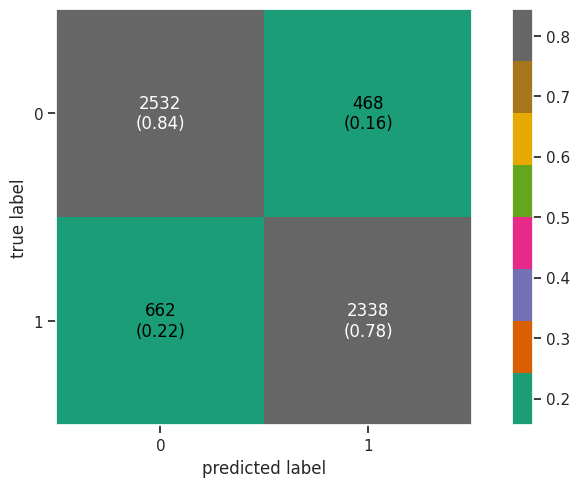

In [ ]:
cm = confusion_matrix(y_true=ytrue, y_pred=ypred)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               cmap = 'Dark2')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Generate a classification report

report = classification_report(ytrue, ypred, target_names = ['benign', 'malignant'])
print(report)

              precision    recall  f1-score   support

      benign       0.79      0.84      0.82      3000
   malignant       0.83      0.78      0.81      3000

    accuracy                           0.81      6000
   macro avg       0.81      0.81      0.81      6000
weighted avg       0.81      0.81      0.81      6000



## 2nd Phase - VGG16 + Transfer Learning ImageNet - BreakHis - PathCam

## Checking environment

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"         # Set for GPU use
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"          # Set for CPU use
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"     # Set for CPU use

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    print('GPU device not found')
    workers = multiprocessing.cpu_count()
    print('You have %d Cores' % workers)
else:
    print('Found GPU at: {}'.format(device_name))
    physical_devices = tf.config.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(physical_devices))
#    tf.config.experimental.set_memory_growth(physical_devices[0], True)
#    tf.debugging.set_log_device_placement(False)

Found GPU at: /device:GPU:0
Num GPUs Available:  1


## Setting environment variables

In [ ]:
# Setting Variables
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 30
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline
mpl.style.use('ggplot')

## Load Data

In [ ]:
# PCam Dataset
!mkdir '/content/train-pcam'
!mkdir '/content/test-pcam'
!unzip -qq '/content/gdrive/MyDrive/train-pcam' -d '/content/train-pcam'
!unzip -qq '/content/gdrive/MyDrive/test-pcam'  -d '/content/test-pcam'

In [ ]:
DB_PATH   = '/content/'
TRAIN_DIR = DB_PATH +'train-pcam/'
TEST_DIR  = DB_PATH + 'test-pcam/'
DIR       = ['train-pcam/', 'test-pcam/']

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/pcam_train_labels.csv', dtype=str)
data = data.astype("string")
data.id = data.id + '.tif'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  string
 1   label   220025 non-null  string
dtypes: string(2)
memory usage: 3.4 MB


In [ ]:
print('Train Shape: ' , data.shape)
data.head()

Train Shape:  (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [ ]:
(data.label.value_counts() / len(data)).to_frame().sort_index().T

,0,1
label,0.59,0.41


In [ ]:
data.dtypes

id       string
label    string
dtype: object

## Preprocessing

In [ ]:
#Check for image string

img = TRAIN_DIR + data.id[5]
fobj = open(img, "rb")
fobj.peek(10)

b'II*\x00\x08\x00\x00\x00\x0f\x00\xfe\x00\x04\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x04\x00\x01\x00\x00\x00`\x00\x00\x00\x01\x01\x04\x00\x01\x00\x00\x00`\x00\x00\x00\x02\x01\x03\x00\x03\x00\x00\x00\xc2\x00\x00\x00\x03\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x06\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00\x0e\x01\x02\x00\x17\x00\x00\x00\xc8\x00\x00\x00\x11\x01\x04\x00\x01\x00\x00\x00\x1f\x01\x00\x00\x15\x01\x03\x00\x01\x00\x00\x00\x03\x00\x00\x00\x16\x01\x04\x00\x01\x00\x00\x00`\x00\x00\x00\x17\x01\x04\x00\x01\x00\x00\x00\x00l\x00\x00\x1c\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x001\x01\x02\x00\x0c\x00\x00\x00\xff\x00\x00\x002\x01\x02\x00\x14\x00\x00\x00\x0b\x01\x00\x00S\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x08\x00\x08\x00\x08\x00{"shape": [96, 96, 3]}\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00tifffile.py\x002018:11:15 17:20:32\x007\x1c;,\x0f-!\x03\x1f\xe5\xc2\xe0J%F

In [ ]:
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [ ]:
num_skipped = 0
for folder_name in DIR:
    folder_path = os.path.join(DB_PATH, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes('tif') in fobj.peek(10)   # check for 'tif' string
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print (fpath)
            # os.remove(fpath)

print("%d Corrupted images" % num_skipped)

/content/train-pcam/_labels.csv
1 Corrupted images


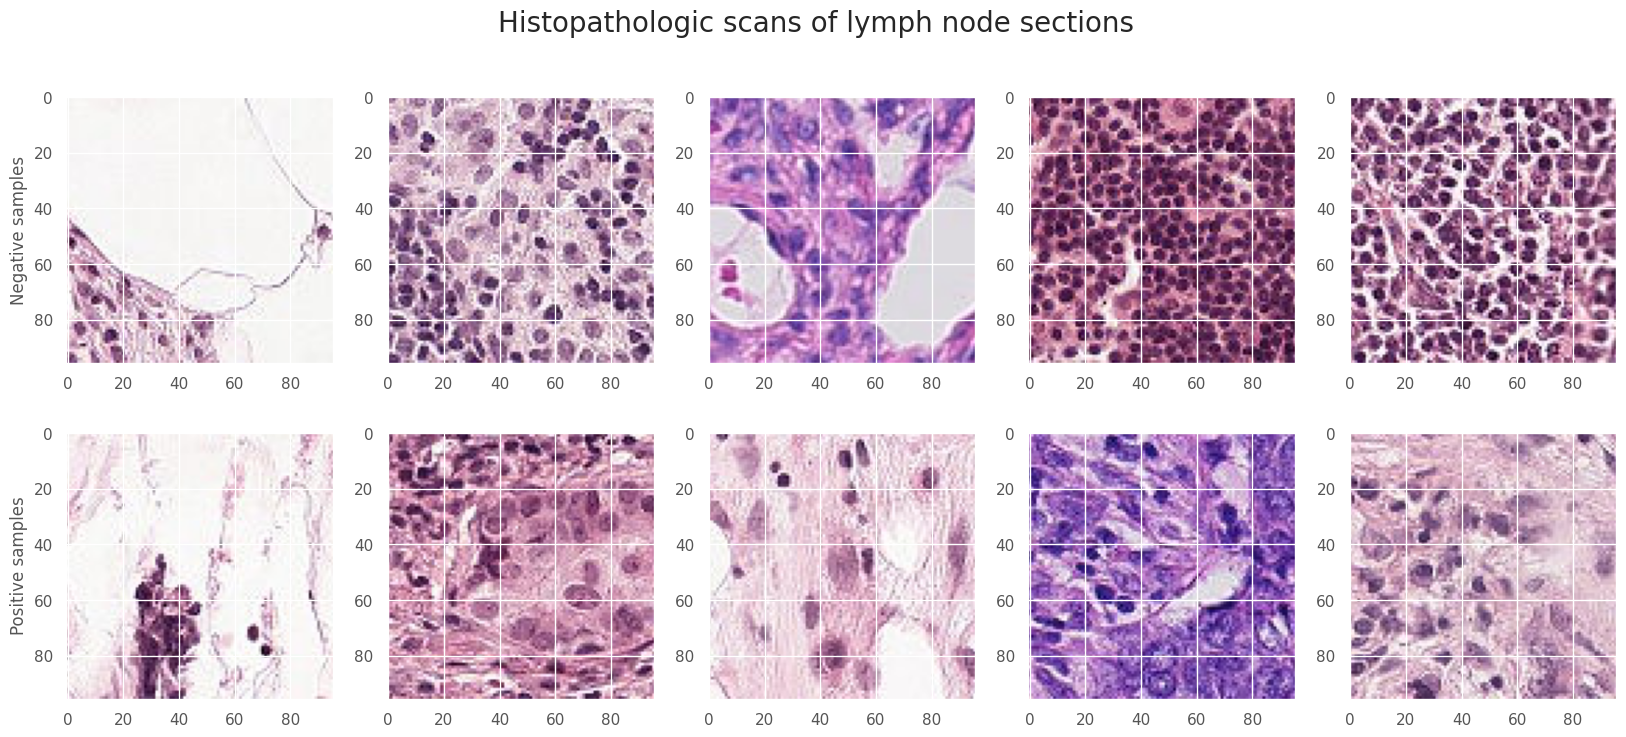

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)


# Negatives
for i, idx in enumerate(data[data['label'] == '0']['id'][:5]):
    path = os.path.join(TRAIN_DIR, idx)
    img = imread(path)
    ax[0,i].imshow(img)
ax[0,0].set_ylabel('Negative samples', size='large')


# # Positives
for i, idx in enumerate(data[data['label'] == '1']['id'][:5]):
    path = os.path.join(TRAIN_DIR, idx)
    img = imread(path)
    ax[1,i].imshow(img)
ax[1,0].set_ylabel('Positive samples', size='large');

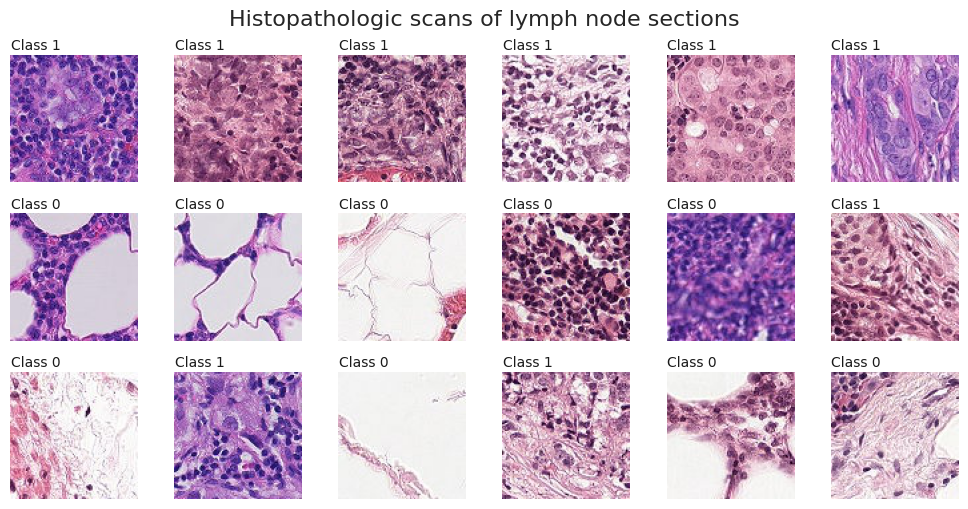

In [ ]:
# plot few Train images

sample = data.sample(n=18).reset_index()
plt.figure(figsize=(10,10))
plt.suptitle('Histopathologic scans of lymph node sections',fontsize=16)
for i, row in sample.iterrows():
    img = imread(TRAIN_DIR + f'{row.id}')
    label = row.label

    plt.subplot(6,6,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=split_size)

train_gen = datagen.flow_from_dataframe(
    dataframe  = data,
    directory  = TRAIN_DIR,
    color_mode = 'rgb',
    x_col      = 'id',
    y_col      = 'label',
    subset     = 'training',
    batch_size = batch_size,
    seed       = seed,
    shuffle    = True,
    class_mode = 'binary',
    target_size = target_shape)

valid_gen = datagen.flow_from_dataframe(
    dataframe  = data,
    directory  = TRAIN_DIR,
    color_mode = 'rgb',
    x_col      = 'id',
    y_col      = 'label',
    subset     = 'validation',
    batch_size = batch_size,
    seed       = seed,
    shuffle    = True,
    class_mode = 'binary',
    target_size = target_shape)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
train_steps = np.ceil(len(train_gen) / batch_size)
val_steps = np.ceil(len(valid_gen) / batch_size)

print('Steps:')
print('Train: %d | Validation: %d ' %(train_steps, val_steps))

Steps:
Train: 172 | Validation: 43 


## DTL Train

In [ ]:
start = time.time()
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K

model.load_weights("1st_train_vgg16_model.h5")

model.compile(optimizer = 'adam',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', Precision(name='Precision'), Recall(name='Recall')]
                 )
# model logs
csv_logger = CSVLogger('cnn_vgg16_DTL_model_logs.csv', append=True)

# making model checkpoints
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('DTL_VGG16_model.h5', save_best_only=True)

history = model.fit(train_gen,
                  epochs = epochs,
                  validation_data = valid_gen,
                  validation_steps = val_steps,
                  callbacks = [model_checkpoint, csv_logger]
                 )

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Epoch 1/5
5501/5501 [==============================] - 685s 124ms/step - loss: 0.4357 - accuracy: 0.8002 - Precision: 0.7779 - Recall: 0.7097 - val_loss: 0.3784 - val_accuracy: 0.8372 - val_Precision: 0.8152 - val_Recall: 0.7476
Epoch 2/5
5501/5501 [==============================] - 678s 123ms/step - loss: 0.3667 - accuracy: 0.8387 - Precision: 0.8228 - Recall: 0.7671 - val_loss: 0.3684 - val_accuracy: 0.8328 - val_Precision: 0.7981 - val_Recall: 0.7778
Epoch 3/5
5501/5501 [==============================] - 678s 123ms/step - loss: 0.3538 - accuracy: 0.8448 - Precision: 0.8313 - Recall: 0.7743 - val_loss: 0.3501 - val_accuracy: 0.8532 - val_Precision: 0.8150 - val_Recall: 0.7931
Epoch 4/5
5501/5501 [==============================] - 680s 124ms/step - loss: 0.3471 - accuracy: 0.8489 - Precision: 0.8370 - Recall: 0.7788 - val_loss: 0.3777 - val_accuracy: 0.8256 - val_Precision: 0.7914 - val_Recall: 0.7655
Epoch 5/5
5501/5501 [==============================] - 677s 123ms/step - loss: 0.342

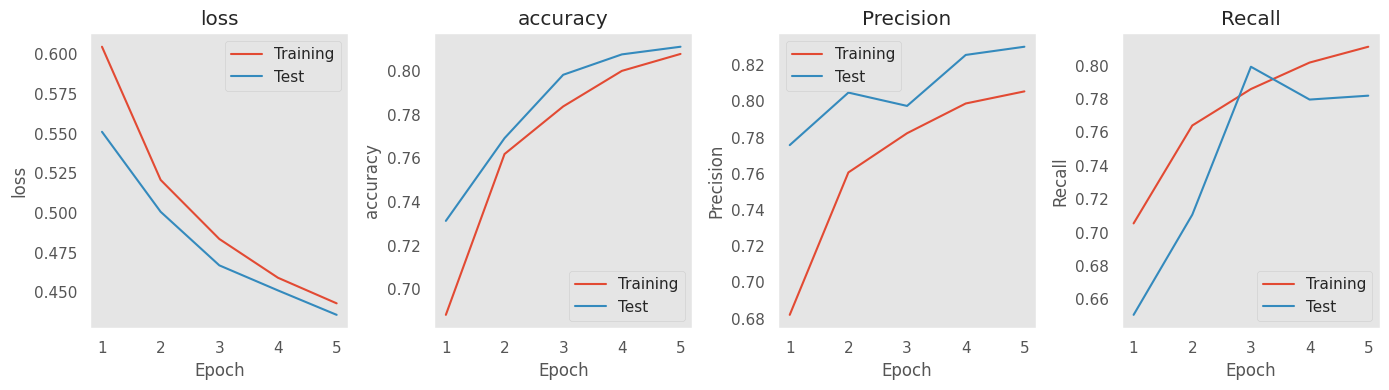

In [ ]:
Plot_Train([train_history])

## Conf Matrix

In [ ]:
test_dataset = data.sample(n=30000)
test_dataset['label'] = test_dataset['label'].astype('string')

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=split_size)

test_gen = datagen.flow_from_dataframe(
    dataframe  = test_dataset,
    directory  = TRAIN_DIR,
    color_mode = 'rgb',
    x_col      = 'id',
    y_col      = 'label',
    subset     = 'validation',
    batch_size = 1,
    seed       = seed,
    shuffle    = False,
    class_mode = 'binary',
    target_size = target_shape)

Found 6000 validated image filenames belonging to 2 classes.


In [ ]:
test_dataset['label'] = test_dataset['label'].astype('int')

In [ ]:
test_steps = np.ceil(len(test_gen) / batch_size)

print('Steps:', test_steps)
print('Test: %d ' %(test_steps))

Steps: 188.0
Test: 188 


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# get field by concatenating batches
ytrue = test_gen.labels
pred = model.predict(test_gen, verbose = 1)
ypred = np.where(pred > 0.5, 1, 0)

6000/6000 [==============================] - 51s 8ms/step


In [ ]:
df_preds = pd.DataFrame(ypred, ytrue)
df_preds.head()

,0
1,0
0,0
1,1
0,0
0,0


In [ ]:
df_preds = pd.DataFrame(ypred, ytrue)
df_preds.head()

,0
1,0
0,0
1,1
0,0
0,0


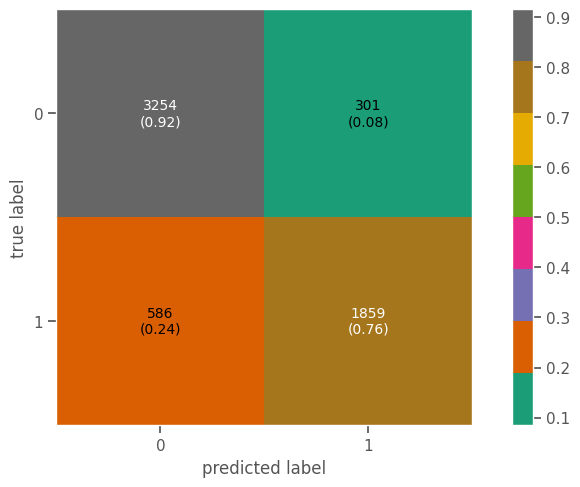

In [ ]:
cm = confusion_matrix(y_true=ytrue, y_pred=ypred)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               cmap = 'Dark2')
plt.show()